# Workout Detector
### The models built here will use keypoints extracted from PoseNet as features and the type of exercise as the label

## Imports

In [1]:
import os
import pandas as pd
import re
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from joblib import dump, load
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

# Preprocess and load data

## Read in the training set

In [2]:
os.listdir()

train_dataset = pd.read_csv("./train.csv")
train_dataset = train_dataset.dropna(axis=0, how ='any')
train_dataset.reset_index(inplace = True, drop=True)

val_dataset = pd.read_csv("./val.csv")
val_dataset = val_dataset.dropna(axis=0, how ='any')
val_dataset.reset_index(inplace = True, drop=True)

test_dataset = pd.read_csv("./test.csv")
test_dataset = test_dataset.dropna(axis=0, how ='any')
test_dataset.reset_index(inplace = True, drop=True)

In [3]:
test_dataset

,keypoints,label
0,"[[213.5549473911214, 114.4022287301363], [220....",squat
1,"[[215.76813005855823, 109.8157075735239], [223...",squat
2,"[[215.51437338275872, 108.14348823563225], [22...",squat
3,"[[215.42181938948602, 108.61974149136931], [22...",squat
4,"[[214.98849040009625, 109.91136051265218], [22...",squat
...,...,...
1939,"[[225.61210059326555, 156.4011553964595], [231...",ohp
1940,"[[228.24726481447598, 156.79948989170256], [23...",ohp
1941,"[[226.83350509516663, 156.38404180007268], [23...",ohp
1942,"[[228.75453132105966, 155.5306222483423], [233...",ohp


## Convert the keypoints into numpy arrays: This is needed because our keypoints come in strings from the csv file

In [4]:
def convert_keypoints_to_np(row):
    """
    For each row convert the keypounts string into a numpy array
    
    literal_eval, parses a string and trys to find a datatype it matches
    It can convert a string("[1, 2]") into -> array([1, 2])  
    """
    arr_string = row["keypoints"]
    row["keypoints"] = np.array(literal_eval(arr_string))
    return row

In [5]:
train_dataset = train_dataset.apply(convert_keypoints_to_np, axis=1)
val_dataset = val_dataset.apply(convert_keypoints_to_np, axis=1)
test_dataset = test_dataset.apply(convert_keypoints_to_np, axis=1)

In [7]:
train_dataset

,keypoints,label
0,"[[209.44327277106208, 76.61273226668582], [216...",squat
1,"[[209.5557964269436, 76.79756465919796], [217....",squat
2,"[[210.0849627457141, 78.36333530608434], [217....",squat
3,"[[210.44733122827606, 82.93815660377551], [217...",squat
4,"[[209.90160150983974, 92.31494568489694], [216...",squat
...,...,...
9999,"[[213.91176533054661, 251.58478068710613], [21...",squat
10000,"[[214.95296256210105, 261.77459447150915], [21...",squat
10001,"[[213.68906849882956, 269.0857215135856], [219...",squat
10002,"[[212.8946201221363, 275.60901641845703], [219...",squat


In [13]:
test_dataset["label"].value_counts()

nothing    732
ohp        637
squat      575
Name: label, dtype: int64

## Drop invalid keypoint rows

In [7]:
def drop_invalid_keypoint_rows(dataset, dataset_type):
    missing_count = 0
    missing_indices = []
    for i in range(0, len(dataset["keypoints"])):
        if str(dataset["keypoints"][i].shape) != "(17, 2)":
            missing_count += 1
            missing_indices.append(i)

    print("The {} data had {} rows with invalid keypoints".format(dataset_type, missing_count))
    dataset = dataset.drop(dataset.index[missing_indices]).reset_index(drop=True)
    
    return dataset

In [8]:
# Drop any rows with keypoints that we couldn't retrieve for training data
train_dataset = drop_invalid_keypoint_rows(train_dataset, "Train")

# Drop any rows with keypoints that we couldn't retrieve for validation data
test_dataset = drop_invalid_keypoint_rows(val_dataset, "Val")

# Drop any rows with keypoints that we couldn't retrieve for test data
test_dataset = drop_invalid_keypoint_rows(test_dataset, "Test")

The Train data had 0 rows with invalid keypoints
The Val data had 0 rows with invalid keypoints
The Test data had 0 rows with invalid keypoints


## Stack keypoints to create 3D Feature vectors and create Train and Test Splits

In [9]:
def flatten_keypoints(row):
    """
    Flatten takes a row that looks like this [[1, 2, 3], [4, 5, 6]] and 
    converts it into a row that looks like [1, 2, 3, 4, 5, 6].
    """
    row["keypoints"] = row["keypoints"].flatten()
    return row

In [10]:
flat_train_dataset = train_dataset.apply(flatten_keypoints, axis=1)
flat_val_dataset = val_dataset.apply(flatten_keypoints, axis=1)
flat_test_dataset = test_dataset.apply(flatten_keypoints, axis=1)

In [11]:
flat_train_dataset["keypoints"].shape

(10004,)

In [12]:
def get_features_and_labels(df):
    """
    np.vstack is needed to turn array(array()) into [[]]
    
    array([array([209.44327277,  76.61273227, 216.78748894,  70.06124498]),
           array([209.55579643,  76.79756466, 217.86113192,  69.49467421])])
    
    to 
    
    [[209.44327277,  76.61273227, 216.78748894,  70.06124498]
     [209.55579643,  76.79756466, 217.86113192,  69.49467421]]
     
    return: 
        features: (samples, features) as numpy array
        labels: (samples,) as numpy array
    """
    features = np.vstack(df['keypoints'].to_numpy())
    labels = df["label"].to_numpy()
    
    return features, labels

In [13]:
# Raw data all converted into numerical representations and cleaned correctly
X_train, Y_train = get_features_and_labels(flat_train_dataset)
X_val, Y_val = get_features_and_labels(flat_val_dataset)
X_test, Y_test = get_features_and_labels(flat_test_dataset)

In [14]:
Y_train

array(['squat', 'squat', 'squat', ..., 'squat', 'squat', 'squat'],
      dtype=object)

## One hot encode the classes

In [16]:
ohe.categories_

[array(['nothing', 'ohp', 'squat'], dtype=object)]

In [15]:
ohe = OneHotEncoder()
ohe.fit(Y_train.reshape(-1, 1))

Y_train = ohe.transform(Y_train.reshape(-1, 1)).toarray()
Y_val = ohe.transform(Y_val.reshape(-1, 1)).toarray()
Y_test = ohe.transform(Y_test.reshape(-1, 1)).toarray()

In [240]:
Y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [241]:
Y_train[534]

array([0., 1., 0.])

## Scale data

In [242]:
# Scaled data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_val = scaler.transform(X_val) 
X_test = scaler.transform(X_test) 

In [247]:
"""
Save the scaler for use later

Example of using this scaler later: 

scaler = load('./scaler.save')

scaled = scaler.transform(features)
"""
dump(scaler, "standard_scaler_jahnus_v1_0.save") 

['standard_scaler_jahnus_v1_0.save']

In [48]:
# X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
# X_val, Y_val = shuffle(X_val, Y_val, random_state=0)     

In [208]:
X_test

array([[-0.0559904 ,  1.61651652, -0.02906334, ...,  0.43316292,
        -0.20663468,  0.44936038],
       [-0.07853199,  1.38118257, -0.1070217 , ...,  0.4473561 ,
        -0.21421845,  0.42748509],
       [-0.01946228,  1.17175209, -0.01062501, ...,  0.44075307,
        -0.22784801,  0.37307237],
       ...,
       [-0.30957019,  2.05410219, -0.32629767, ..., -0.44485344,
        -0.11793176, -0.21506936],
       [-0.35486981,  2.33601705, -0.36870274, ..., -0.24876602,
        -0.06818239, -0.25171653],
       [-0.40163649,  2.42785606, -0.4236616 , ..., -0.14116886,
        -0.004074  , -0.27152942]])

# Define model

## Train neural network on dataset

In [209]:
# Model imports
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [210]:
# Imports
def build_model():
    # Neural network
    model = Sequential()
    model.add(Dense(6, input_dim=34, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [216]:
model = build_model()
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), shuffle=True)

Train on 10004 samples, validate on 3229 samples
Epoch 1/50
10004/10004 [==============================] - 1s 58us/step - loss: 0.9707 - acc: 0.5682 - val_loss: 0.7691 - val_acc: 0.7643
Epoch 2/50
10004/10004 [==============================] - 1s 84us/step - loss: 0.6039 - acc: 0.7818 - val_loss: 0.6429 - val_acc: 0.7612
Epoch 3/50
10004/10004 [==============================] - 0s 45us/step - loss: 0.4496 - acc: 0.8596 - val_loss: 0.5720 - val_acc: 0.8272
Epoch 4/50
10004/10004 [==============================] - 0s 40us/step - loss: 0.3652 - acc: 0.9043 - val_loss: 0.5225 - val_acc: 0.8572
Epoch 5/50
10004/10004 [==============================] - 1s 59us/step - loss: 0.3039 - acc: 0.9228 - val_loss: 0.4706 - val_acc: 0.8743
Epoch 6/50
10004/10004 [==============================] - 0s 49us/step - loss: 0.2561 - acc: 0.9453 - val_loss: 0.4059 - val_acc: 0.9381
Epoch 7/50
10004/10004 [==============================] - ETA: 0s - loss: 0.2216 - acc: 0.952 - 1s 57us/step - loss: 0.2185 - acc

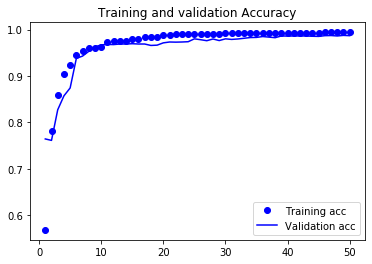

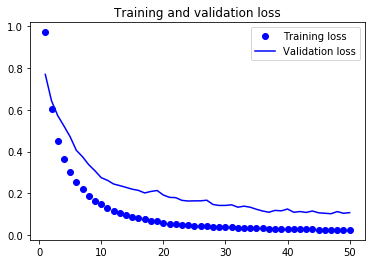

In [222]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Test model on test set

In [223]:
def evaluate_set(X_labels, Y_labels):
    # Arg Maxed to obtain labels
    # Predictions
    X_labels = model.predict(X_labels)
    X_labels = np.argmax(X_labels, axis=1)
    
    # Ground truth
    Y_labels = np.argmax(Y_labels, axis=1)
    
    acc_score = accuracy_score(X_labels, Y_labels)
    print("The accuracy of this distribution is: {}".format(acc_score))

In [225]:
evaluate_set(X_test, Y_test)

The accuracy of this distribution is: 0.9869928770517188


## Save model

In [221]:
model.save('jahnus_v1_0.h5')  # creates a HDF5 file 'my_model.h5'